In [6]:
import sys
sys.path.append('..')
import config
from autoencoding import AutoEncoder

In [8]:
import os
model_path = config.MODEL_PATH
model = AutoEncoder.from_h5(model_path)

../autoencoding.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/dense_1_i..., outputs=sigmoid.0)`
  output=model.layers[idx_code_layer].output)


In [16]:
# train_dir = config.TRAIN_DIR
train_dir = '../data/train2'
files = [os.path.join(train_dir, f) for f in os.listdir(train_dir)][:15000]

# Look at how well autoencoder predicts input

In [17]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def get_test_input(files, k=5):
    files = random.sample(files, k=k)
    return files, [np.load(f) * 2000 for f in files]

def compare_predictions(test_input, model):
    plt.figure(figsize=(12, 24))
    f, axarr = plt.subplots(len(test_input), sharex=True, sharey=True)
    for i, X in enumerate(test_input):
        xshape = X.shape[0]
        y_hat = model.predict(X.reshape(1, xshape))
        axarr[i].plot(X)
        axarr[i].plot(y_hat.reshape((xshape,)), color='r')

['../data/train2/01 I Hop.mp3 - sample 16.npy', '../data/train2/07 Can T.mp3 - sample 17.npy', '../data/train2/02 - Summer Romance.mp3 - sample 18.npy', '../data/train2/The Old .mp3 - sample 14.npy', '../data/train2/01 - Everybody Knows This Is Nowhe.mp3 - sample 11.npy']


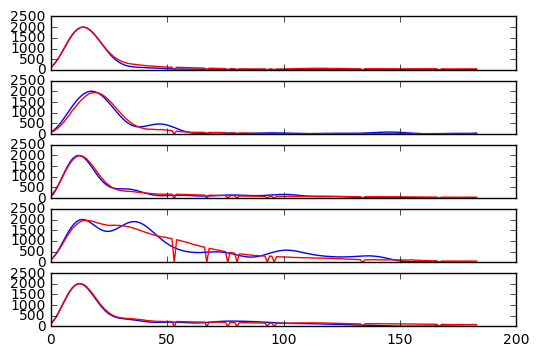

In [18]:
test_files, test_input = get_test_input(files)
compare_predictions(test_input, model)
print(test_files)

In [19]:
print(y_hat.shape)
plt.scatter(range(y_hat.shape[1]), y_hat.reshape((y_hat.shape[1],)))
y_hat

NameError: name 'y_hat' is not defined

# Look at distribution of codes. Are they binary?

In [20]:
test_features = [np.load(f) * 2000 for f in files]

In [21]:
X_test = np.array(test_features)
preds = model.predict(X_test)

In [22]:
preds

array([[ 153.22573853,  270.76898193,  428.01177979, ...,   13.23231888,
          12.88175011,   12.8541832 ],
       [ 151.35339355,  263.61151123,  416.98522949, ...,   17.75581741,
          21.66184807,   19.04059982],
       [ 152.81932068,  272.60214233,  431.640625  , ...,   19.60956192,
          14.93274117,   16.96345139],
       ..., 
       [  40.77105331,   49.21012878,   51.41022491, ...,  322.09078979,
         314.12911987,  308.64993286],
       [ 139.30162048,  230.49076843,  352.90719604, ...,   27.73399734,
          21.6462574 ,   28.97829819],
       [ 149.72953796,  258.60305786,  407.55795288, ...,  137.48397827,
         131.03115845,  139.65341187]], dtype=float32)

In [23]:
from collections import Counter
c = Counter(round(v, 2) for *_, v in np.ndenumerate(preds))
    

In [26]:
plt.scatter(c.keys(), c.values())

TypeError: float() argument must be a string or a number, not 'dict_values'

TypeError: float() argument must be a string or a number, not 'dict_values'

# Evaluate search

In [41]:
def init_db(encoder, files, feature_size):
    items = np.zeros((len(files), feature_size))
    for i, f in enumerate(files):
        X = np.load(f)
        X = X.reshape((1, X.shape[0])) 
        items[i, :] = X
    codes = encoder.predict(items)
    db = [(f, code) for f, code in zip(files, codes)]
    return db

def linear_search(db, q, score_func):
    scores = [(k, score_func(q, v)) for k, v in db]
    return sorted(scores, key=lambda x: x[1], reverse=True)

def cosine_distance(x1, x2):
    return x1.dot(x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))

In [42]:
%%time
db = init_db(encoder, files, X.shape[0])

CPU times: user 13.6 s, sys: 4.13 s, total: 17.7 s
Wall time: 23.3 s


In [52]:
test = random.choice(files)
test

'/home/dante_gates/repos/music-rec/data/train2/16 Guitar Flute & String.mp3 - sample 7.npy'

In [53]:
q = np.load(test)
q = encoder.predict(q.reshape((1, q.shape[0]))).transpose().reshape((32,))
q.shape

(32,)

In [54]:
%%time
linear_search(db, q, cosine_distance)

CPU times: user 544 ms, sys: 12 ms, total: 556 ms
Wall time: 1e+03 ms


[('/home/dante_gates/repos/music-rec/data/train2/16 Guitar Flute & String.mp3 - sample 7.npy',
  1.0),
 ('/home/dante_gates/repos/music-rec/data/train2/02 Life .mp3 - sample 15.npy',
  0.9999947),
 ('/home/dante_gates/repos/music-rec/data/train2/11 A Lac.mp3 - sample 7.npy',
  0.99998564),
 ('/home/dante_gates/repos/music-rec/data/train2/03 Nude.mp3 - sample 1.npy',
  0.99997866),
 ('/home/dante_gates/repos/music-rec/data/train2/16 Guitar Flute & String.mp3 - sample 4.npy',
  0.99997842),
 ('/home/dante_gates/repos/music-rec/data/train2/16 Guitar Flute & String.mp3 - sample 17.npy',
  0.99997222),
 ('/home/dante_gates/repos/music-rec/data/train2/08 - Ass.mp3 - sample 4.npy',
  0.99996746),
 ('/home/dante_gates/repos/music-rec/data/train2/20 Love Never Ends.mp3 - sample 10.npy',
  0.99995226),
 ('/home/dante_gates/repos/music-rec/data/train2/03 The T.mp3 - sample 18.npy',
  0.99995214),
 ('/home/dante_gates/repos/music-rec/data/train2/04 Dee.mp3 - sample 11.npy',
  0.99995112),
 ('/home

In [46]:
db[:100]

[('/home/dante_gates/repos/music-rec/data/train2/02 I Sti.mp3 - sample 7.npy',
  array([  1.64583104e-03,   1.04536138e-01,   9.99735296e-01,
           7.38867931e-03,   8.45631719e-01,   1.41738099e-03,
           8.82509828e-01,   3.40382934e-01,   1.43652512e-02,
           1.37023218e-02,   1.10322073e-01,   1.67022377e-01,
           8.90502334e-01,   1.51335014e-04,   9.89840448e-01,
           9.51535940e-01,   7.60342479e-01,   2.16832943e-02,
           1.50738418e-01,   9.68608975e-01,   2.06335355e-02,
           2.81316787e-03,   5.63253252e-07,   6.84816897e-01,
           7.68549323e-01,   3.88020612e-02,   1.11695593e-02,
           3.60608041e-01,   9.15402889e-01,   9.33489621e-01,
           6.23788871e-03,   5.06907178e-04], dtype=float32)),
 ('/home/dante_gates/repos/music-rec/data/train2/07 The F.mp3 - sample 16.npy',
  array([ 0.14187673,  0.13507946,  0.97164512,  0.11845519,  0.65213639,
          0.05582308,  0.83310431,  0.39156574,  0.44381931,  0.3029508 ,


[[  4.08158870e-04   2.98940986e-01   9.99761701e-01   2.39068940e-02
    3.27116668e-01   2.36990675e-03   4.48699117e-01   1.08120330e-01
    4.63268999e-03   2.67122518e-02   5.14683187e-01   1.12046733e-01
    9.06424880e-01   2.43168164e-04   9.86537278e-01   8.79902244e-01
    5.87677002e-01   4.31161821e-01   3.96401808e-02   9.38800633e-01
    4.18459289e-02   3.63892643e-03   3.36999983e-06   8.00646245e-01
    8.75230193e-01   1.84025556e-01   1.80582777e-02   3.90070617e-01
    8.75557423e-01   6.25512004e-01   6.87003210e-02   4.78560629e-04]]
[[   60.06554794    57.93207932    63.9679184      0.            50.60951614
      0.            53.09954834     0.            41.05578232
     32.84540558    26.25908661     0.             0.            11.28286552
     17.63336754    23.2993927     34.40384674    50.43247223
     56.02549744    80.02990723    99.92665863   115.0056839    161.40498352
    190.86174011   230.69604492   270.14639282   311.88479614     0.             0.

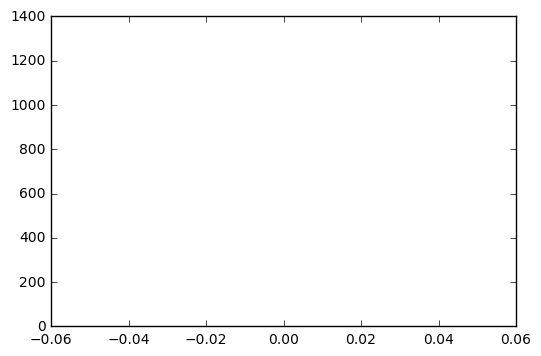

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
X = np.load(test)
# plt.plot(X)
X = X.reshape((1, X.shape[0]))
plt.plot(model.predict(X), color='r')
print(encoder.predict(X))
print(model.predict(X))

In [34]:
print(sum(sum(X < .1)))
print(sum(sum(X >= .1)))

84
100
